# Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loading Data

In [5]:
# Make this a preprocess function

def load_data(filename, labels_present=True):

    data = pd.read_csv(filename)
    
    X = data.iloc[:,1:].to_numpy().astype("float32").reshape(-1,28,28)/255.0
    print("Training images shape:", X.shape)

    if labels_present:
        Y = data["label"].to_numpy().astype("float32").reshape(-1,)
        print("Training labels shape:", Y.shape)
        return X, Y

    else:
        return X

In [6]:
data_dir = "./data/"

X, Y = load_data(data_dir + "train.csv")


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)


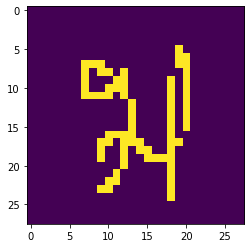

In [7]:
plt.imshow(X[5])
plt.show()

In [8]:
len(np.unique(Y))

10

In [9]:
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

from tqdm import tqdm

c:\users\toby\appdata\local\programs\python\python36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper Functions

Could remove cuda's, as hard to test

In [10]:
 
from torch.autograd import Variable

def cuda(v):
    if torch.cuda.is_available():
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):       
    return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if torch.cuda.is_available():
        return v.detach().cpu().numpy()
    return v.detach().numpy()

# Data Loaders

In [11]:
import random
import sys

# A dataset class that can be used by PyTorch data loaders
class CustomDataset(Dataset):
    
    def __init__(self, X, Y, num_classes=1, aug_transform=None):

        self.X = X
        # Convert labels to a tensor for training
        # self.Y = nn.functional.one_hot(toTensor(Y).long(), num_classes=num_classes)
        self.Y = toTensor(Y).long()
        
        X, Y = None, None

        self.xi_preprocessing_transform = transforms.Compose([
                                            transforms.ToTensor(),
                                          ])
        self.yi_preprocessing_transform = None
        self.aug_transform = aug_transform
        if self.aug_transform is not None:
            print("[WARNING]: Dataset loaded with augmentations set, make sure this is training only")
        
        self.nitems = self.X.shape[0]
        
        self.xi = None
        self.yi = None
        
    def __getitem__(self, index):

        X, Y = None, None # Avoiding accidently using X and Y instead of self.X

        xi = self.X[index]
        yi = self.Y[index]
        
        xi_final = xi
        yi_final = yi
        
        seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the transformations

        # First augment the data, if we have some augmentations to apply
        if self.aug_transform is not None:
            random.seed(seed)

            trans_dict = self.aug_transform(image=xi)
            # Apply to the images before doing standard transforms
            xi = trans_dict["image"]

        # Convert examples to a tensor
        if self.xi_preprocessing_transform is not None:
            random.seed(seed) # apply this seed to img transforms
            xi_final = self.xi_preprocessing_transform(xi)

        return xi_final,  yi_final
    
    def __len__(self):
        return self.nitems

# Model Zoo

## BasicCNN

In [12]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
  # num_classes is the number of COUNTS to return
    def __init__(self, in_channels=1, num_classes=10):
        super(ConvNet, self).__init__()

        self.num_classes = num_classes

        self.name = "ConvNet"

        # Layer 1 variables:
        layer1_kernel_num = 16
        self.layer1 = nn.Sequential(

            # Kernel details
            nn.Conv2d(in_channels, layer1_kernel_num, kernel_size=5, stride=1, padding=2),

            # Normalisation
            nn.BatchNorm2d(layer1_kernel_num), # Should match output size of layer

            # Activation Function (if any)
            nn.ReLU(),

            # Halves the input size
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Layer 2 variables:
        layer2_kernel_num = 32
        self.layer2 = nn.Sequential(

            nn.Conv2d(layer1_kernel_num, layer2_kernel_num, kernel_size=5, stride=1, padding=2),

            nn.BatchNorm2d(layer2_kernel_num),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2))

        # Try sequential here
        self.fc1 = nn.Linear(7*7*layer2_kernel_num, num_classes)

        self.output_layer = nn.Softmax(dim=1)

        print("Model initialised.")

  # x: numpy array with shape (256,256,3)
    def forward(self, x):

        out = self.layer1(x)

        out = self.layer2(out)

        # Flatten output of Conv part
        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.output_layer(out)
        return out

# TODO - predict function
# Should start at a raw image

In [13]:
# Code which goes through the results collected during training and plots them.
def plotResults(trainingResults):

    metrics_available = trainingResults[list(trainingResults.keys())[0]].keys()

    for i, metric in enumerate(metrics_available):
        
        plt.figure(figsize=(10,5))

        plt.title(metric + " over the course of training")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        # Values were recorded for train and validation results
        for phase in trainingResults.keys():

            epochs = len(trainingResults[phase][metric])
            epochs_range = range(1,epochs+1)

            plt.plot(epochs_range,trainingResults[phase][metric],label=phase)

        plt.legend()
        plt.show()

In [14]:
def count_correct(preds, labels, debug=False):

    correct_count = 0.0
    
    predicted_labels = torch.argmax(preds, dim=1)
    correct_count += (predicted_labels == labels).sum().item()
    
    if debug:
        print("Predicted:",toNumpy(predicted_labels))
        print("Labels:",toNumpy(labels))
        print("Correct Count:",correct_count)
    
    return correct_count

In [15]:
def train(model_class,model_init_params,Xtr,Ytr,valSplitSize=0.2,batch_size=32,num_epochs=20,lr=1e-3,save=True,verbose=0):
    
    X, Y = None, None
    
    trainSize = int((1.0 - valSplitSize)*len(Xtr))
    print("Train set size:",trainSize)
    # Validation set
    Xv, Yv = Xtr[trainSize:], Ytr[trainSize:]
    # Train set
    Xtr, Ytr = Xtr[:trainSize], Ytr[:trainSize]

    print("Training Dataset sizes:","[", Xtr.shape, Ytr.shape,"]")
    print("Validation Dataset sizes:","[", Xv.shape, Yv.shape,"]")
    
    device = torch.device(f'cpu')
    
    model = model_class(**model_init_params).to(device)
    print("Model Loaded:",model.name)
    
    # Make datasets
    train_dataset = CustomDataset(Xtr, Ytr, num_classes=model.num_classes)
    val_dataset = CustomDataset(Xv, Yv, num_classes=model.num_classes)

    # Make loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=0) 
    
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=0) 
    
    criterion = nn.CrossEntropyLoss()
    print("Loss Function:",criterion)
    
        # Uses our learning rate parameter
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    results = dict()
    for phase in ["training","validation"]:
        results[phase] = {"loss": [], "accuracy": []}
    
    # Train the model
    for epoch in range(num_epochs):
        
        results_this_epoch = dict()
        for phase in ["training","validation"]:
            results_this_epoch[phase] = {"loss": [], "accuracy": []}
        
        # Needed since we switch to .eval() during the validation stage
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader)):

            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            preds = model(images)
            
            loss = criterion(preds, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            results_this_epoch["training"]["loss"].append(loss.item())
            results_this_epoch["training"]["accuracy"].append(count_correct(preds, labels))
            
        # Validation
        
        # Making sure we aren't using dropouts and also aren't trainined the model
        model.eval()
        with torch.no_grad():
            
            for i, (images, labels) in enumerate(tqdm(val_loader)):

                images = images.to(device)
                labels = labels.to(device)
                # Forward pass
                preds = model(images)

                loss = criterion(preds, labels)
                # No update step

                results_this_epoch["validation"]["loss"].append(loss.item())
                results_this_epoch["validation"]["accuracy"].append(count_correct(preds, labels))
            
        print('Epoch [{}/{}]'.format(epoch+1, num_epochs))

        for phase in results_this_epoch.keys():
            for metric in results_this_epoch[phase].keys():
                if metric == "loss":
                    results[phase][metric].append(np.mean(results_this_epoch[phase][metric]))
                elif metric == "accuracy":
                    if phase == "training":
                        total = len(Ytr)
                    elif phase == "validation":
                        total = len(Yv)
                    results[phase][metric].append(np.sum(results_this_epoch[phase][metric])/total)
                    
                if (verbose > 0):
                    print('[{}] {}: {:.4f}'.format(phase, metric, results[phase][metric][-1]))
                    
    plotResults(results)
    
    # TODO - Early stopping

Train set size: 12000
Training Dataset sizes: [ (12000, 28, 28) (12000,) ]
Validation Dataset sizes: [ (3000, 28, 28) (3000,) ]
Model initialised.
Model Loaded: ConvNet
Loss Function: CrossEntropyLoss()


100%|██████████| 24/24 [00:02<00:00,  9.51it/s]


Epoch [1/10]
[training] loss: 1.6093
[training] accuracy: 0.8915
[validation] loss: 1.5484
[validation] accuracy: 0.9370


100%|██████████| 24/24 [00:02<00:00,  9.76it/s]


Epoch [2/10]
[training] loss: 1.4927
[training] accuracy: 0.9779
[validation] loss: 1.5264
[validation] accuracy: 0.9520


100%|██████████| 24/24 [00:02<00:00,  9.59it/s]


Epoch [3/10]
[training] loss: 1.4811
[training] accuracy: 0.9852
[validation] loss: 1.5128
[validation] accuracy: 0.9590


100%|██████████| 24/24 [00:02<00:00,  9.10it/s]


Epoch [4/10]
[training] loss: 1.4754
[training] accuracy: 0.9894
[validation] loss: 1.5031
[validation] accuracy: 0.9670


100%|██████████| 24/24 [00:02<00:00,  9.65it/s]


Epoch [5/10]
[training] loss: 1.4737
[training] accuracy: 0.9904
[validation] loss: 1.5031
[validation] accuracy: 0.9680


100%|██████████| 24/24 [00:02<00:00,  9.60it/s]


Epoch [6/10]
[training] loss: 1.4711
[training] accuracy: 0.9921
[validation] loss: 1.4970
[validation] accuracy: 0.9687


100%|██████████| 24/24 [00:02<00:00,  9.55it/s]


Epoch [7/10]
[training] loss: 1.4694
[training] accuracy: 0.9935
[validation] loss: 1.4944
[validation] accuracy: 0.9743


100%|██████████| 24/24 [00:02<00:00,  8.54it/s]


Epoch [8/10]
[training] loss: 1.4681
[training] accuracy: 0.9947
[validation] loss: 1.4857
[validation] accuracy: 0.9813


100%|██████████| 24/24 [00:02<00:00,  9.71it/s]


Epoch [9/10]
[training] loss: 1.4672
[training] accuracy: 0.9950
[validation] loss: 1.4910
[validation] accuracy: 0.9753


100%|██████████| 24/24 [00:02<00:00,  9.36it/s]


Epoch [10/10]
[training] loss: 1.4665
[training] accuracy: 0.9958
[validation] loss: 1.4911
[validation] accuracy: 0.9733


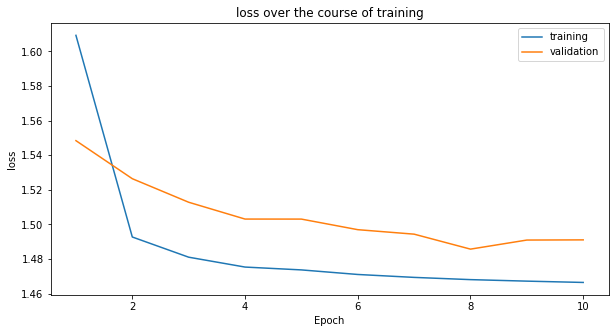

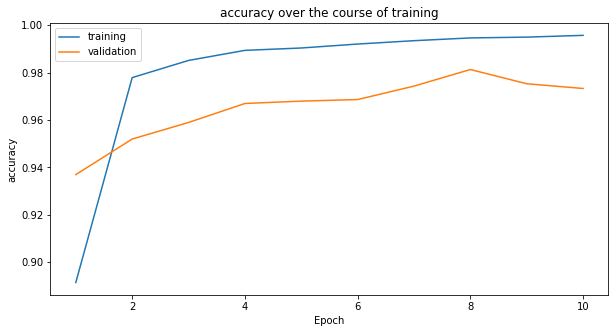

In [17]:
train(ConvNet,{},X[:15000],Y[:15000],verbose=1,num_epochs=10, batch_size=128)

In [14]:
test_labels = torch.tensor([0,2,1])
test_preds = torch.tensor([[0.4,0.5,0.2],
                          [0.2,0.4,0.5],
                          [0.2,0.6,0.5]])

count_correct(test_preds, test_labels)

2.0